In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Convolutional Neural Network

## Pytorch Flowers DataSet

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import time
import numpy as np
import pandas as pd
import random

from collections.abc import Callable
from typing import Literal

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import v2

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
import torchvision
torchvision.__version__, torch.__version__

('0.18.0+cu121', '2.3.0+cu121')

In [4]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'
subDir = 'flower_photos'
modelDir = './models'
altName = 'torch_all'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)

EPOCHS = 201 # number of epochs
BATCH_SIZE = 16
ALPHA = 0.001 # learning rate

TRAIN_SIZE = 184*BATCH_SIZE

# Input Image size
IMG_HEIGHT = 186 
IMG_WIDTH = 186  

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [5]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [6]:
'''
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))
'''

"\nprint ('Is CUDA available: ', torch.cuda.is_available())\n\nprint ('CUDA version: ', torch.version.cuda )\n\nprint ('Current Device ID: ', torch.cuda.current_device())\n\nprint ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))\n"

In [7]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


## Read Flowers data set

In [8]:
###---------------
### Transformation
###---------------

train_transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.RandomRotation(degrees=(-45,45)),
    v2.CenterCrop(IMG_HEIGHT),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5), 
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

test_transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.CenterCrop(IMG_HEIGHT), 
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

data_dir = os.path.join(inpDir, subDir)

train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(data_dir, transform=test_transform)

In [9]:
image, label = next(iter(train_dataset))
image.shape, label

(torch.Size([3, 186, 186]), 0)

In [10]:
dataset_size = len(train_dataset)

indices = torch.randperm(dataset_size).tolist()

train_dataset = torch.utils.data.Subset(train_dataset,indices[:TRAIN_SIZE])

test_dataset = torch.utils.data.Subset(test_dataset,indices[TRAIN_SIZE:])

len(train_dataset), len(test_dataset)

(2944, 726)

In [11]:
class_names = {count : nClass for count, nClass in enumerate(train_dataset.dataset.classes)}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

## Data Loader

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

184 45


## Visualization of data

In [13]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0)) ## Change to channel last (180*180*3) instead of (3*180*180)

    means = np.array([0.485, 0.456, 0.406])
    
    stds = np.array([0.229, 0.224, 0.225])
    
    img = stds * img + means ## De normalize data
    
    img = np.clip(img, 0, 1) # clip values between 0 and 1
    
    ax.imshow(img)
    
    ax.axis('off')

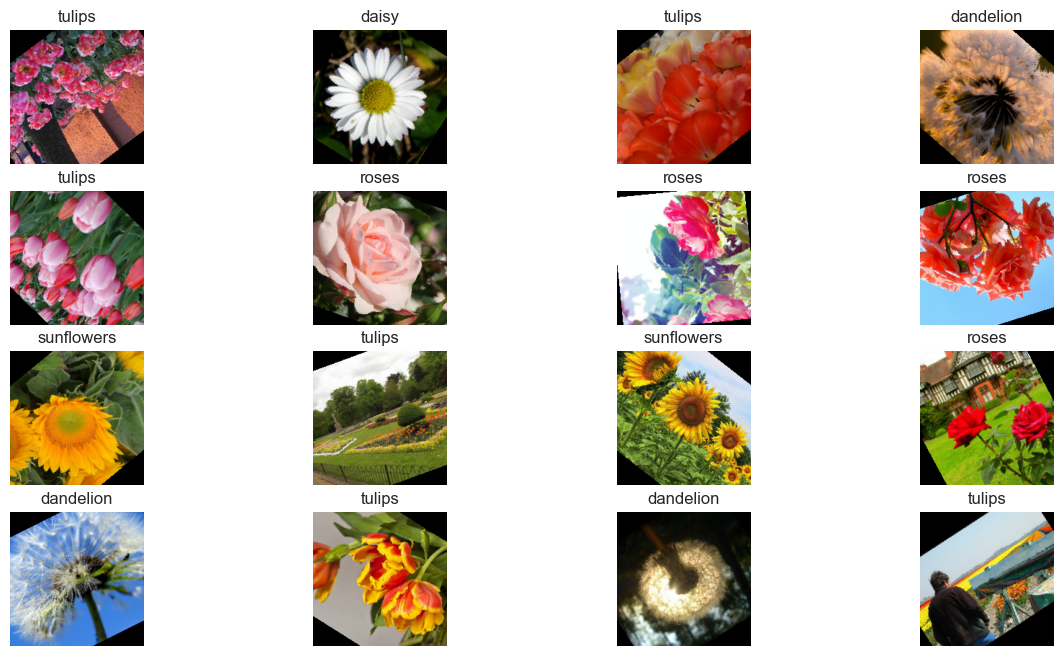

In [14]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//4, 4, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

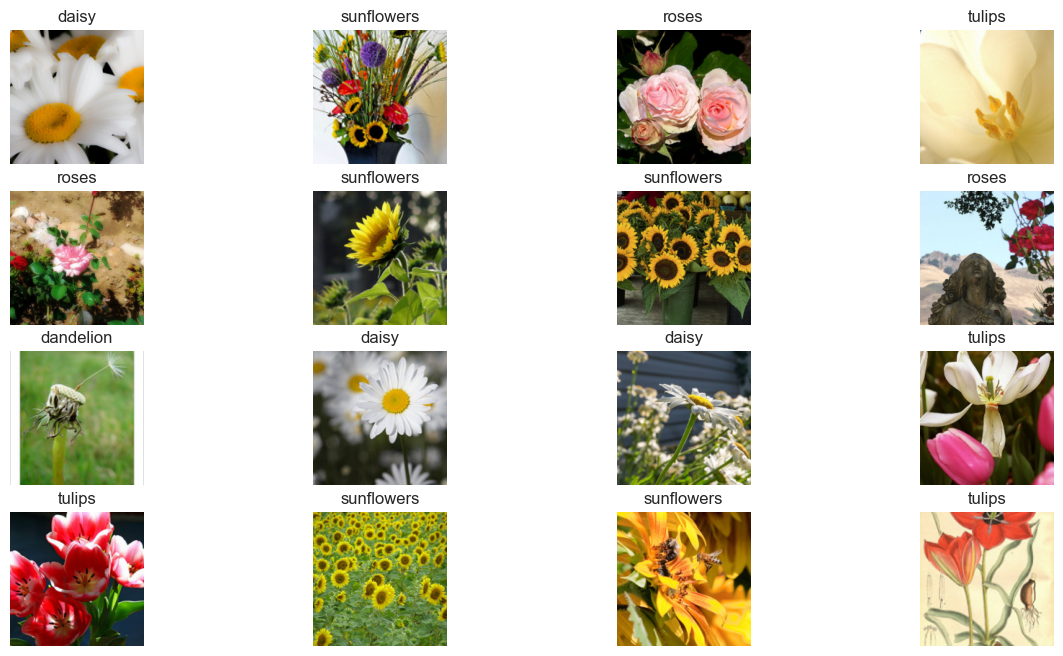

In [15]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//4, 4, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

## Building Model

In [16]:
class LeNet(nn.Module):
    
    def __init__(self, numChannels, classes):
        
        # call the parent constructor 
        super(LeNet, self).__init__()
        
        # Dropouts
        drop1 = 0.3
        drop2 = 0.3    
        drop3 = 0.4        
        drop4 = 0.5
        drop5 = 0.5        
        
        ## Define Layers
        
        ## Layer 1
        out_channels1 = 32
        
        self.conv1 = nn.Conv2d(in_channels = numChannels,
                              out_channels = out_channels1,
                              kernel_size=(3,3))  ## 184*184*32
        
        self.bn1 = nn.BatchNorm2d(out_channels1)
        
        self.actv1 = nn.LeakyReLU()
        
        self.maxpool1 = nn.MaxPool2d(kernel_size = (4,4),
                                    stride = (4,4)) ## 46*46*32
        
        self.dropout1 = nn.Dropout(p=drop1)  
        
        
        ## Layer 2
        out_channels2 = 64
        
        self.conv2 = nn.Conv2d(in_channels = out_channels1,
                              out_channels = out_channels2,
                              kernel_size=(3,3))  ## 44*44*64
        
        self.bn2 = nn.BatchNorm2d(out_channels2)
        
        self.actv2 = nn.LeakyReLU()
        
        self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2),
                                    stride = (2,2)) ## 22*22*64
        
        self.dropout2 = nn.Dropout(p=drop2)
        
        ## Layer 3
        out_channels3 = 128
        
        self.conv3 = nn.Conv2d(in_channels = out_channels2,
                              out_channels = out_channels3,
                              kernel_size=(3,3))  ## 20*20*128
        
        self.bn3 = nn.BatchNorm2d(out_channels3)
        
        self.actv3 = nn.LeakyReLU()
        
        self.maxpool3 = nn.MaxPool2d(kernel_size = (2,2),
                                    stride = (2,2)) ## 10*10*128
        
        self.dropout3 = nn.Dropout(p=drop3)
        
        ## Layer 4
        out_channels4= 256
        
        self.conv4= nn.Conv2d(in_channels = out_channels3,
                              out_channels = out_channels4,
                              kernel_size=(3,3))  ## 8*8*256
        
        self.bn4= nn.BatchNorm2d(out_channels4)
        
        self.actv4= nn.LeakyReLU()
        
        self.maxpool4= nn.MaxPool2d(kernel_size = (2,2),
                                    stride = (2,2)) ## 4*4*256
        
        self.dropout4= nn.Dropout(p=drop4)
        
        ## Head
        out_channels5= 512
        
        self.fc1= nn.Linear(in_features = 4*4*out_channels4,
                              out_features = out_channels5)  ## 512
        
        self.bn5= nn.BatchNorm1d(out_channels5)
        
        self.actv5= nn.LeakyReLU()
        
        self.dropout5= nn.Dropout(p=drop5)
        
        ## output layer        
        self.fc2= nn.Linear(in_features = out_channels5,
                              out_features = classes)  ## 512
        
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        
        ##layer 1
        x= self.conv1(x)
        x= self.bn1(x)
        x= self.actv1(x)
        x= self.maxpool1(x)
        x= self.dropout1(x)
        
        ##layer 2
        x= self.conv2(x)
        x= self.bn2(x)
        x= self.actv2(x)
        x= self.maxpool2(x)
        x= self.dropout2(x)
        
        ##layer 3
        x= self.conv3(x)
        x= self.bn3(x)
        x= self.actv3(x)
        x= self.maxpool3(x)
        x= self.dropout3(x)
        
        ##layer 4
        x= self.conv4(x)
        x= self.bn4(x)
        x= self.actv4(x)
        x= self.maxpool4(x)
        x= self.dropout4(x)
       
        # flattening layer
        x = torch.flatten(x,1)
        
        ## head 
        x= self.fc1(x)
        x= self.bn5(x)
        x= self.actv5(x)
        x= self.dropout5(x)
        
        ## output 
        x= self.fc2(x)
        return self.logSoftmax(x)  

In [17]:
numChannels = 3

numClasses = len(class_names)

model = LeNet(numChannels=numChannels, classes=numClasses).to(device)

summary(model,(numChannels,IMG_HEIGHT,IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 184, 184]             896
       BatchNorm2d-2         [-1, 32, 184, 184]              64
         LeakyReLU-3         [-1, 32, 184, 184]               0
         MaxPool2d-4           [-1, 32, 46, 46]               0
           Dropout-5           [-1, 32, 46, 46]               0
            Conv2d-6           [-1, 64, 44, 44]          18,496
       BatchNorm2d-7           [-1, 64, 44, 44]             128
         LeakyReLU-8           [-1, 64, 44, 44]               0
         MaxPool2d-9           [-1, 64, 22, 22]               0
          Dropout-10           [-1, 64, 22, 22]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
      BatchNorm2d-12          [-1, 128, 20, 20]             256
        LeakyReLU-13          [-1, 128, 20, 20]               0
        MaxPool2d-14          [-1, 128,

In [18]:
## Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                             lr = ALPHA) # weight_decay = 0.01

# Define loss fn
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor= LR_FACTOR,
                                                       patience=LR_PATIENCE,
                                                       min_lr = 1e-5)

## Initialize a dictionary to store training history

H = {
    'Epoch'      : [],
    'Train Loss' : [],
    'Test Loss'  : [],
    'Train Acc'  : [],
    'Test Acc'   : [],
    'Alpha'      : [],
    'Patience'   : [] 
}
print("Done")

Done


In [19]:
# min loss
minLoss = float('inf')

# Path to save model
savePath = os.path.join(modelDir, subDir,'flowers.pth')

for epoch in range(EPOCHS):
    # timer
    epochStart = time.time()
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_dataloader):
        
        model.train()
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)   
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        pred = torch.argmax(outputs, axis=1)
        batch_loss = loss_fn(outputs,labels)
        batch_acc = accuracy_score(labels.cpu().numpy(),pred.cpu().numpy())
        
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item()*inputs.size(0) 
        train_acc += batch_acc*inputs.size(0) 
        
    train_loss/=len(train_dataset)
    train_acc/=len(train_dataset)  
    
    H['Train Loss'].append(train_loss) 
    H['Train Acc'].append(train_acc) 
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        model.eval()
        
        for i, data in enumerate(test_dataloader):
        
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)   
        
            outputs = model(inputs)
            pred = torch.argmax(outputs, axis=1)
            batch_loss = loss_fn(outputs,labels)
            batch_acc = accuracy_score(labels.cpu().numpy(),pred.cpu().numpy())
        
            test_loss += batch_loss.item()*inputs.size(0) 
            test_acc += batch_acc*inputs.size(0) 
        
        test_loss/=len(test_dataset)
        test_acc/=len(test_dataset)  
    
        H['Test Loss'].append(train_loss) 
        H['Test Acc'].append(train_acc) 
    
    H['Epoch'].append(epoch)
    
    # Step the scheduler
    lr_scheduler.step(test_loss)
    
    ## Add Early stopping/ Saving model
    if test_loss < minLoss:
        minLoss = test_loss
        counter = 0
        # saving model
        torch.save({'epoch':epoch+1,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict,
                    'loss': loss_fn}, savePath)
    else:
        counter += 1
    if counter> PATIENCE:
        break                
    #-----------------------------------------------------------
    
    curr_alpha = lr_scheduler.get_last_lr()[0]
    H['Alpha'].append(curr_alpha)
    
    H['Patience'].append(counter)
    
    if epoch%10==0:
        ## print model traing and testing info
        print(f"Epoch : {epoch:3d}/{EPOCHS:3d}",end=" ")
        print(f"Loss : {train_loss:.6f}/{test_loss:.6f}, Accuracy : {train_acc:.6f}/{test_acc:.6f}",end=" ")        
        print(f"Alpha : {curr_alpha:.6f}, ES : {counter:2d}",end=" ")        
        print(f"Epoch time : {time.time()-epochStart:.3f} sec")        

Epoch :   0/201 Loss : 1.286710/1.882172, Accuracy : 0.476902/0.282369 Alpha : 0.001000, ES :  0 Epoch time : 76.744 sec
Epoch :  10/201 Loss : 0.819776/0.890034, Accuracy : 0.677989/0.663912 Alpha : 0.001000, ES :  1 Epoch time : 76.771 sec
Epoch :  20/201 Loss : 0.679261/0.713832, Accuracy : 0.734035/0.719008 Alpha : 0.001000, ES :  0 Epoch time : 76.294 sec
Epoch :  30/201 Loss : 0.655662/0.686169, Accuracy : 0.746943/0.738292 Alpha : 0.001000, ES :  2 Epoch time : 76.047 sec
Epoch :  40/201 Loss : 0.582057/0.780186, Accuracy : 0.788383/0.695592 Alpha : 0.001000, ES :  4 Epoch time : 76.002 sec
Epoch :  50/201 Loss : 0.548546/0.778677, Accuracy : 0.785326/0.730028 Alpha : 0.001000, ES :  4 Epoch time : 75.851 sec
Epoch :  60/201 Loss : 0.457733/0.578413, Accuracy : 0.834579/0.778237 Alpha : 0.000100, ES :  1 Epoch time : 75.646 sec
Epoch :  70/201 Loss : 0.420862/0.622171, Accuracy : 0.841712/0.776860 Alpha : 0.000010, ES : 11 Epoch time : 75.946 sec
